# Read ME



The [training](https://drive.google.com/file/d/1tfo6qm8zB5Eb7TY8WQGey-SqwBiC-3uO/view?usp=sharing) and [test](https://drive.google.com/file/d/1--yMo6lHVrkU9iqXUjLIJpKLYaz7QfLF/view?usp=sharing) data were downloaded from the [Zoo Galaxy](https://data.galaxyzoo.org/#section-21) platform, corresponding to Galaxy Zoo 2 ([images_gz2.zip](https://zenodo.org/records/3565489#.Y3vFKS-l0eY)).  

These data are stored in "[.pkl](https://drive.google.com/drive/folders/1XalRlt11sYmU11op2z3xPnVsRt8Pz0VM?usp=drive_link)" format instead of the original ".jpg" format to facilitate handling. The dataset consists of 10,000 training images and 5,000 test images. The information is reduced to 75 pixels per image, arranged in a 5x5 pixel grid with three color channels. To visualize the galaxy, it is necessary to reconstruct the image.

# Set up

## Packages

In [ ]:
!pip install hdbscan

In [ ]:
# Mount Google Drive to access and store files
# Comment out this cell if running the script locally

from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Force remount to ensure access


Mounted at /content/drive


In [ ]:
# Import necessary libraries for file handling, data processing, and machine learning
import os                # For file and directory operations
import io                # For handling byte streams
import time              # For measuring execution time
import math              # For mathematical operations like square roots
import h5py              # For working with HDF5 files
import random            # For generating random numbers
import requests          # For making HTTP requests (e.g., downloading files)
import numpy as np       # For numerical operations with arrays and matrices
import pandas as pd      # For data manipulation and analysis using DataFrames
import matplotlib.pyplot as plt  # For plotting and visualizing data/images

# Machine learning tools for dimensionality reduction and data scaling
from sklearn.decomposition import IncrementalPCA  # For incremental PCA to reduce data dimensions
from sklearn.preprocessing import StandardScaler  # For scaling data before applying PCA (zero mean, unit variance)
import joblib                                      # For saving and loading machine learning models



In [ ]:
# Import HDBSCAN for density-based clustering
import hdbscan

# Import cosine distance metric for measuring similarity between data points
from sklearn.metrics.pairwise import cosine_distances


## Funtions

In [ ]:
def load_logdata(data='train'):
    """
    Downloads and loads preprocessed training or testing log data from Google Drive.

    Parameters:
    - data (str): Specifies which log data to load ('train' or 'test').

    Returns:
    - DATA (numpy array or None): The loaded log data if successful, otherwise None.
    """

    # Define Google Drive file IDs for train and test log data
    if data.lower() == 'train':
        file_id = '1wDuS7VDzPIFEb7w_L6q1oe85ONsfEntC'  # File ID for log data train

    elif data.lower() == 'test':
        file_id = '1wAKlz1x5GZ0HbJYL90KcgVJKuDW2ZfIv'  # File ID for log data test

    else:
        print('Error: Type of data invalid')  # Handle incorrect input
        return None

    # Construct the download URL
    url = f"https://drive.google.com/uc?export=download&id={file_id}"

    # Request file from Google Drive
    respuesta = requests.get(url)

    # Load the file as a byte stream
    file_stream = io.BytesIO(respuesta.content)

    # Load the dataset using joblib
    DATA = pd.read_csv(file_stream)

    # Confirm successful data loading
    print(f'{data.lower()} data loaded\nShape: {DATA.shape}')

    return DATA

def load_data(data='train'):
    """
    Downloads and loads preprocessed training or testing data from Google Drive.

    Parameters:
    - data (str): Specifies which dataset to load ('train' or 'test').

    Returns:
    - DATA (numpy array or None): The loaded dataset if successful, otherwise None.
    """

    # Define Google Drive file IDs for train and test datasets
    if data.lower() == 'train':
        file_id = '1-8JHObeY7kaU0qLt0p7WDFRJf6A6iYFN'  # File ID for training data

    elif data.lower() == 'test':
        file_id = '1bdjlyKp02O04uGkixX1E4mQMkUjvWRbL'  # File ID for test data

    else:
        print('Error: Type of data invalid')  # Handle incorrect input
        return None

    # Construct the download URL
    url = f"https://drive.google.com/uc?export=download&id={file_id}"

    # Request file from Google Drive
    respuesta = requests.get(url)

    # Load the file as a byte stream
    file_stream = io.BytesIO(respuesta.content)

    # Load the dataset using joblib
    DATA = joblib.load(file_stream)

    # Confirm successful data loading
    print(f'{data.lower()} data loaded\nShape: {DATA.shape}')

    return DATA

def load_model(model='ipca'):
    """
    Downloads and loads a machine learning model from Google Drive.

    Parameters:
    - model (str): Specifies which model to load ('ipca' or 'scaler').

    Returns:
    - DATA (object or None): The loaded model object if successful, otherwise None.
    """

    # Define Google Drive file IDs for different models
    if model.lower() == 'ipca':
        file_id = '1s_reCv_xE5jQ_pKUtoPDsH6qPRJId_OL'  # File ID for the Incremental PCA model

    elif model.lower() == 'scaler':
        file_id = '1kl2dynGnyYr70_ChOOzQT3z1t3n7RB9w'  # File ID for the StandardScaler model

    else:
        print('Error: Invalid model type specified')  # Handle incorrect input
        return None

    # Construct the Google Drive download URL
    url = f"https://drive.google.com/uc?export=download&id={file_id}"

    # Send a request to download the model file
    respuesta = requests.get(url)

    # Convert the downloaded content into a byte stream
    file_stream = io.BytesIO(respuesta.content)

    # Load the model using joblib
    MODEL = joblib.load(file_stream)

    # Confirm successful model loading
    print(f'Model loaded: {MODEL}')

    return MODEL

def single_reconverter(data):
    """
    Takes a single PCA-transformed data point, reverses the PCA and scaling transformations,
    and normalizes it before reshaping it into an image.

    Parameters:
    - data (numpy array): A single data point in PCA-reduced form.

    Returns:
    - norm_centroides (numpy array): Reconstructed image (174x174x3).
    """
    data = data.reshape(1, -1)  # Ensure data is a 2D array
    centroides = scaler.inverse_transform(data)  # Reverse standard scaling
    centroides = ipca.inverse_transform(centroides)  # Reverse PCA transformation
    norm_centroides = normalized(centroides)  # Normalize pixel values
    norm_centroides = norm_centroides.reshape(174, 174, 3)  # Reshape into an image
    return norm_centroides


def reconverter(data):
    """
    Reconstructs multiple PCA-reduced data points back into images.

    Parameters:
    - data (numpy array): Multiple PCA-transformed data points.

    Returns:
    - norm_centroides (numpy array): Reconstructed images with normalized pixel values.
    """
    centroides = scaler.inverse_transform(data)  # Reverse scaling
    centroides = ipca.inverse_transform(centroides)  # Reverse PCA
    norm_centroides = normalized(centroides)  # Normalize pixel values
    return norm_centroides


def normalized(data):
    """
    Normalizes data to the range [0,1] using min-max scaling.

    Parameters:
    - data (numpy array): Input data.

    Returns:
    - norm (numpy array): Normalized data.
    """
    norm = (data - data.min()) / (data.max() - data.min())  # Min-max normalization
    return norm

def clusters_histograms(log_data, type_data):
    """
    Generates histograms showing the frequency of each galaxy class for each cluster.

    Parameters:
    - log_data (DataFrame): The dataset containing 'prediction' (cluster assignments) and 'gz2_class' (class labels).
    - type_data (str): Describes the dataset type ('Train' or 'Test') to be displayed in the plot title.

    Returns:
    - None
    """

    # Extract unique clusters and sort class labels alphabetically
    clusters = log_data['prediction'].unique()
    order = sorted(log_data['gz2_class'].unique())

    # Initialize subplot position counter
    poss = 1

    # Create a figure to hold the histograms with a large size
    plt.figure(figsize=(20, 15))

    # Set the overall title for the plot
    plt.suptitle(f'Histograms for each cluster ({type_data})')

    # Loop through each cluster to generate and plot its histogram
    for c in sorted(clusters):

        # Get the frequency of each class within the current cluster
        hismo = log_data[log_data['prediction'] == c]['gz2_class'].value_counts()

        # Reindex the frequency series to ensure all class labels are present, filling missing with 0
        hismo = hismo.reindex(order, fill_value=0)

        # Create a subplot for each cluster's histogram, dynamically adjusting the layout
        plt.subplot(math.ceil(n_clusters / 5), 5, poss)

        # Plot the histogram as a bar chart
        plt.bar(hismo.index, hismo)

        # Set axis labels and title for this specific cluster's histogram
        plt.xlabel('Class')
        plt.ylabel('Frequency')
        plt.title(f'Class Frequency for Cluster {c}')

        # Add grid lines along the y-axis for better readability
        plt.grid(axis='y')

        # Increment the subplot position counter
        poss += 1

    # Adjust the layout to avoid overlapping of subplots
    plt.tight_layout()

    # Save the figure as a PDF
    plt.savefig(f'{root_result}Histograms_for_each_cluster_{type_data}.pdf')

    # Display the figure
    plt.show()

    return None


def histogram(labels, clusters, name):
    """
    Plots a histogram of cluster distribution with a semi-logarithmic scale.

    Parameters:
    - labels (array-like): Cluster assignments for each sample.
    - bins (int or sequence): Number of bins or bin edges for the histogram.
    - name (str): File name for saving the plot.

    Returns:
    - None
    """

    # Define bin edges for the histogram, covering all cluster indices
    bins = np.arange(-1,clusters)

    # Set up the figure size for better visualization
    plt.figure(figsize=(15, 4))

    # Set the title of the plot
    plt.title('Distribution for Each Cluster')

    # Use a semi-logarithmic scale to highlight differences in frequency
    plt.semilogy()

    # Plot a histogram showing the frequency of samples in each cluster
    frecuencia, clases, _ = plt.hist(labels, bins=bins, rwidth=0.8)

    # Label the axes
    plt.xlabel('Cluster')
    plt.ylabel('Frequency')

    # Set cluster numbers as x-axis ticks (centered between bins)
    plt.xticks(bins[:-1] + 0.5, bins[:-1])

    # Add a grid along the y-axis for better readability
    plt.grid(axis='y')

    # Adjust layout to prevent overlapping elements
    plt.tight_layout()

    # Save the figure as a PDF file in the results directory
    plt.savefig(f'{root_result}{name}.pdf')

    # Display the plot
    plt.show()

    return None

## Directories

In [ ]:
### Drive roots ####

root_train ='/content/drive/MyDrive/Practicas_Profesionales/Data/PKLs/train_data.pkl'
root_test ='/content/drive/MyDrive/Practicas_Profesionales/Data/PKLs/test_data.pkl'

root_ipca = '/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/reduce_dimensions.pkl'
root_scaler = '/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/scaler.pkl'

root_log_data = '/content/drive/MyDrive/Practicas_Profesionales/Data/Log_data/'
root_result = '/content/drive/MyDrive/Practicas_Profesionales/Results/HDB/'

In [ ]:
# ### Local roots ####

# root_train ='/home/tonathiu/Fisica/Practicas_Profesionales/Data/train_data.pkl'
# root_test ='/home/tonathiu/Fisica/Practicas_Profesionales/Data/test_data.pkl'

# root_ipca = '/home/tonathiu/Fisica/Practicas_Profesionales/Codes/Models/Pre-processing/reduce_dimensions.pkl'
# root_scaler = '/home/tonathiu/Fisica/Practicas_Profesionales/Codes/Models/Pre-processing/scaler.pkl'

# root_result = '/home/tonathiu/Fisica/Practicas_Profesionales/Results/HDB/'

## Load Models

In [ ]:
# Load models from drive

ipca = load_model('ipca')
scaler = load_model('scaler')

Model loaded: IncrementalPCA(batch_size=100, n_components=75)
Model loaded: StandardScaler()


In [ ]:
# ## Run if you have file of ipca & scaler on your computer/Drive

# ipca = joblib.load(root_ipca)
# scaler = joblib.load(root_scaler)

## Load Log Data

In [ ]:
# Load the training and testing log data from Google Drive
log_data_train = load_logdata('train')  # Load the log data for the training set
log_data_test = load_logdata('test')    # Load the log data for the testing set

train data loaded
Shape: (10000, 3)
test data loaded
Shape: (10000, 3)


# [HDBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html)(Train)

## Load Train Data

In [ ]:
# Load dataset from drive

train_data = load_data('train')

# Compute pairwise cosine distances for the training data

train_cosine_dist = cosine_distances(train_data)

train data loaded
Shape: (10000, 75)


In [ ]:
# ## Run if you have datasets on your computer/Drive

# train_data = joblib.load(root_train)
# Test_data = joblib.load(root_test)

In [ ]:
# Initialize HDBSCAN clustering with precomputed cosine distances

hdb = hdbscan.HDBSCAN(
    metric='precomputed',             # Use a precomputed distance matrix (cosine distance)
    min_cluster_size=6,               # Minimum number of points required to form a cluster
    cluster_selection_epsilon=0.3,    # Controls the minimum separation between clusters
    cluster_selection_method="leaf",  # Selects clusters from the most refined partition
    gen_min_span_tree=True,           # Generates the minimum spanning tree for visualization
    prediction_data=True
)

# Fit the HDBSCAN model to the precomputed cosine distance matrix
hdb.fit(train_cosine_dist)  # Ensure that 'train_cosine_dist' contains pairwise distances


/usr/local/lib/python3.11/dist-packages/hdbscan/hdbscan_.py:1320: UserWarning: Cannot generate prediction data for non-vectorspace inputs -- access to the source data ratherthan mere distances is required!
  warn(


HDBSCAN(cluster_selection_epsilon=0.3, cluster_selection_method='leaf',
        gen_min_span_tree=True, metric='precomputed', min_cluster_size=6,
        prediction_data=True)

## Minimum Spanning Tree

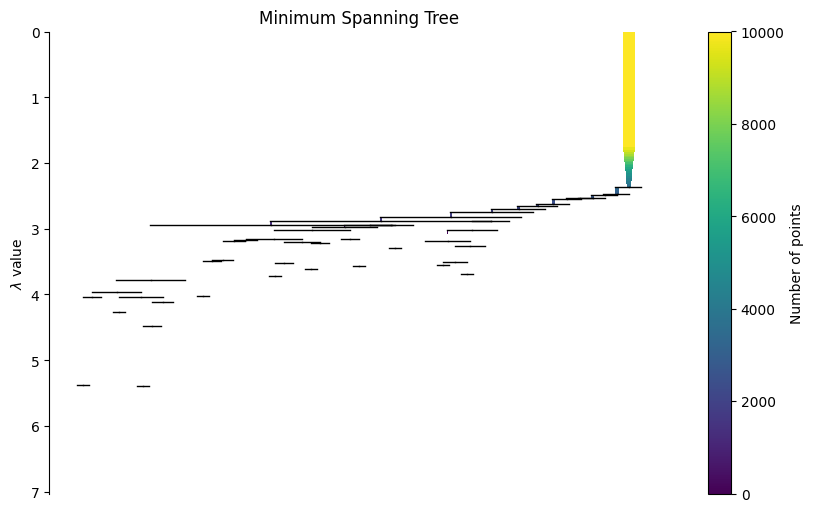

In [ ]:
# Create a figure for visualizing the hierarchical clustering tree
plt.figure(figsize=(10, 6))

# Plot the condensed hierarchical tree generated by HDBSCAN
hdb.condensed_tree_.plot()

# Set the title for the plot
plt.title("Minimum Spanning Tree")

plt.savefig(f'{root_result}Arbol_de_minima_expansion_Train_HDB.pdf')

# Display the tree plot
plt.show()


## Clasification

In [ ]:
# Predict cluster labels for the test dataset using the trained HC model

labels = hdb.labels_

log_data_train['prediction'] = labels
display(log_data_train.head())

# Obtain the number of clusters

n_clusters = len(np.unique(labels))

,dr7objid,asset_id,gz2_class,prediction
0,587733079744512108,253043,Ec,-1
1,588295842860105844,238739,Ec,-1
2,587730847961645743,274697,Ser,21
3,587732053237366856,50470,Er,19
4,587739096983076959,117625,Sb,-1


## Histogram

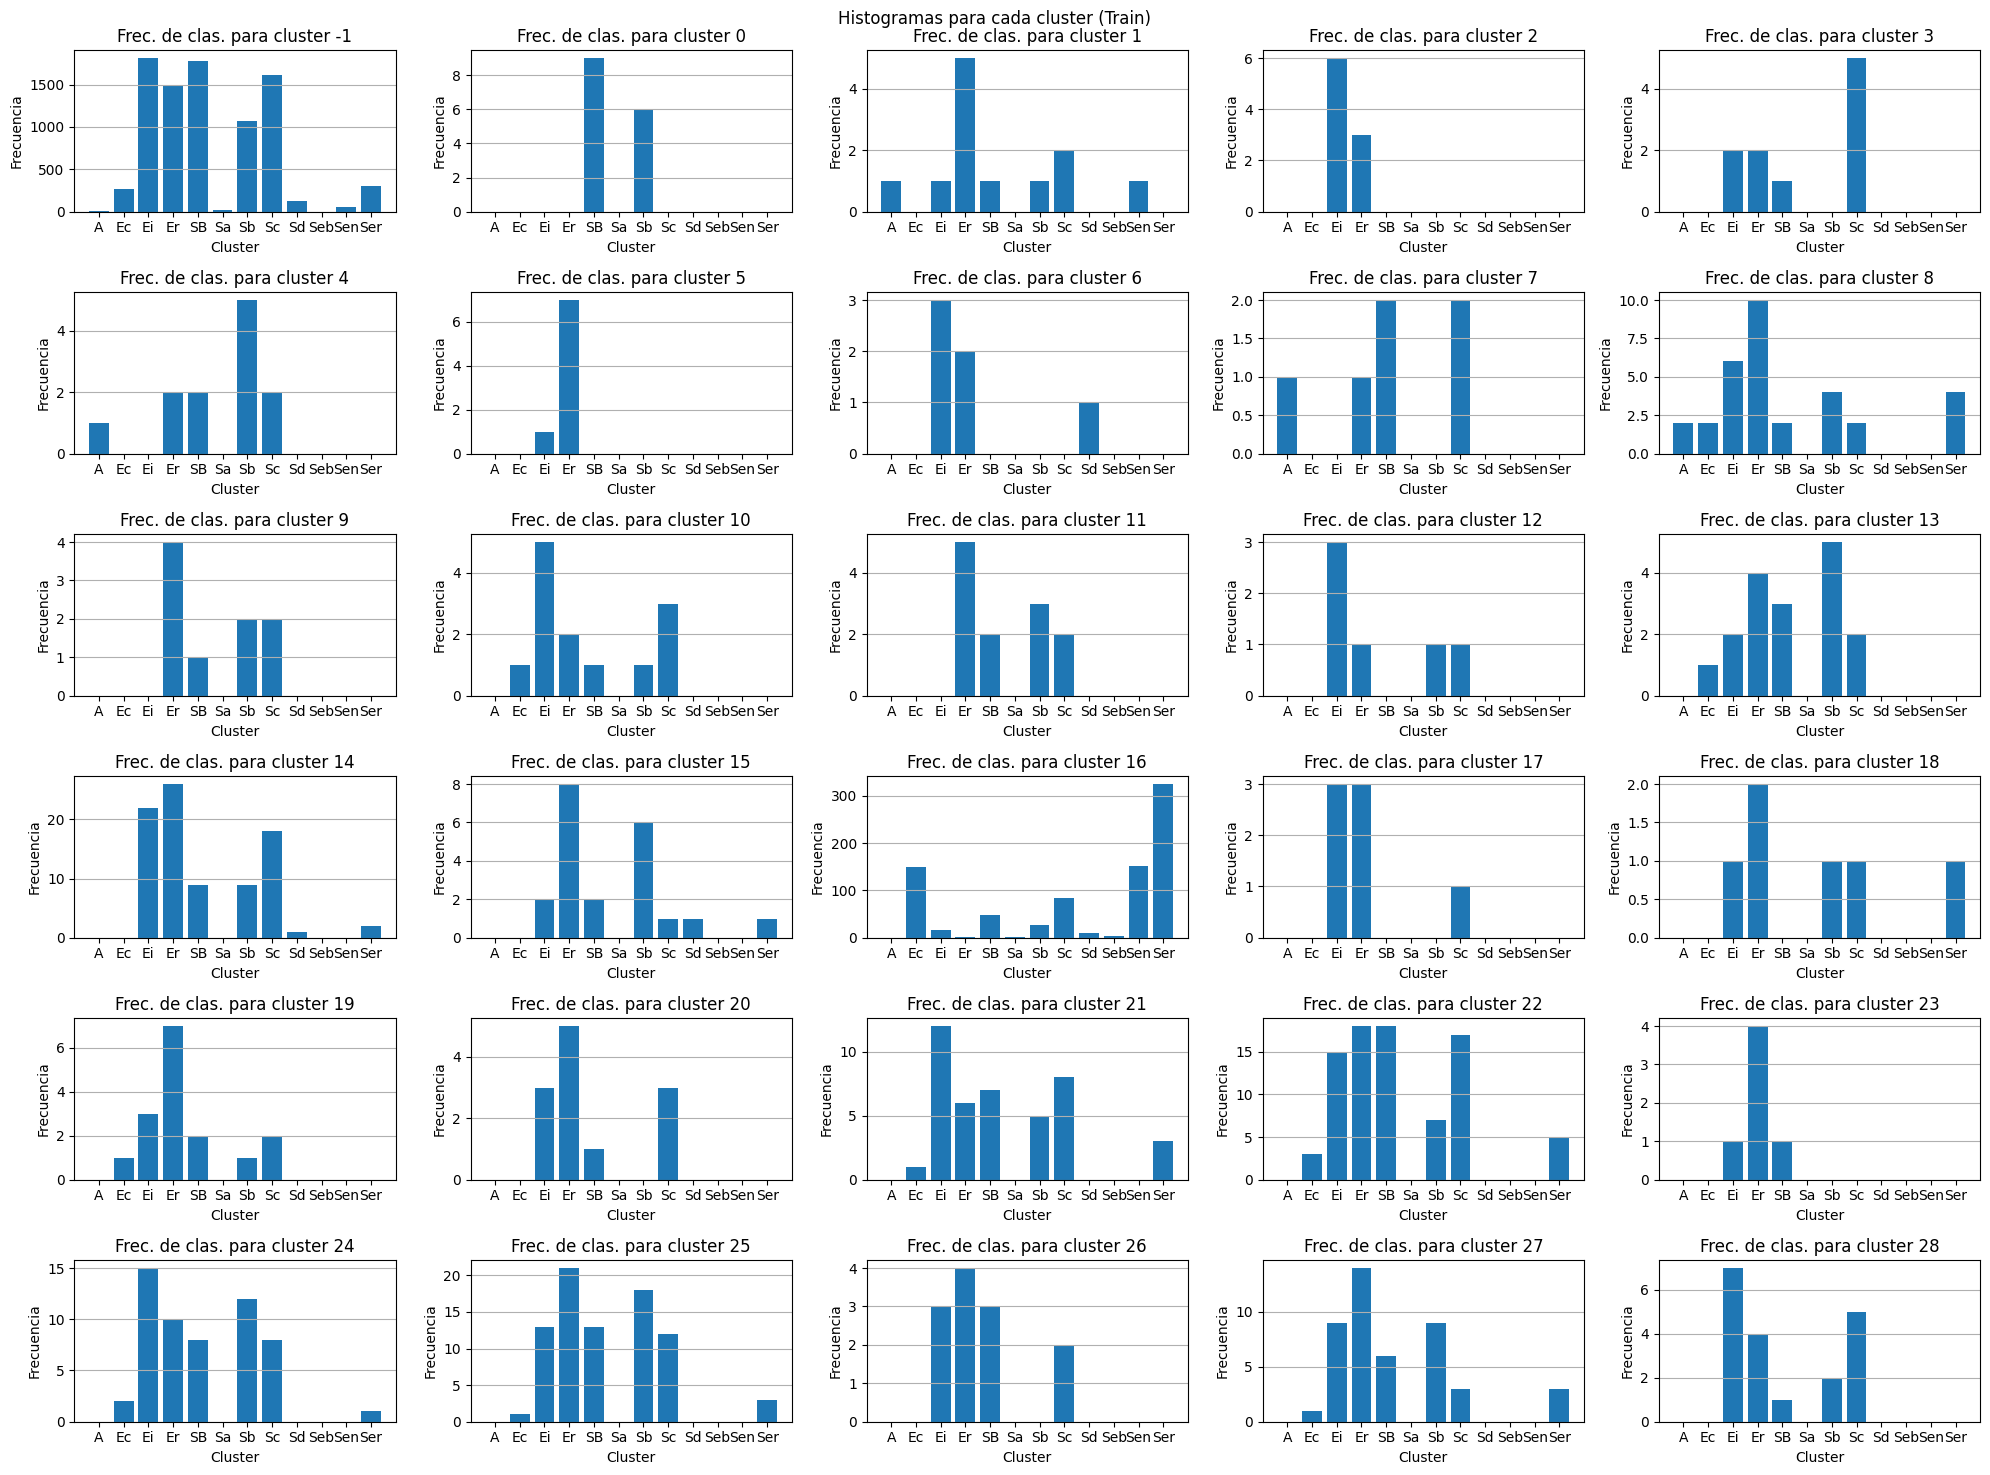

In [ ]:
# Generate histograms for each cluster showing the distribution of galaxy classes in the training dataset
clusters_histograms(log_data_train,'Train')

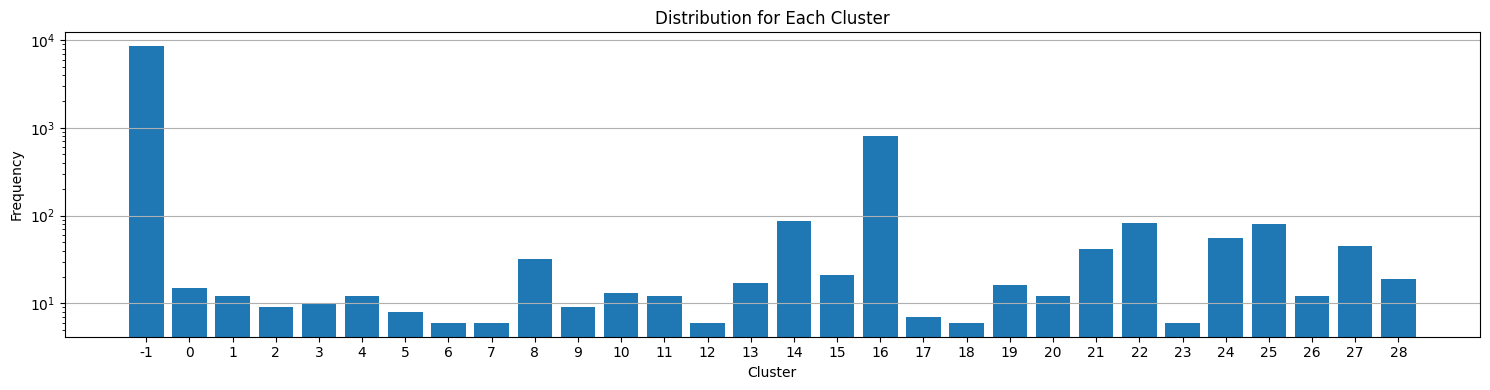

In [ ]:
# Plot and save a histogram showing the distribution of cluster labels in the training data
histogram(labels, n_clusters, 'Histograma_Train_HDB')

## Centroids

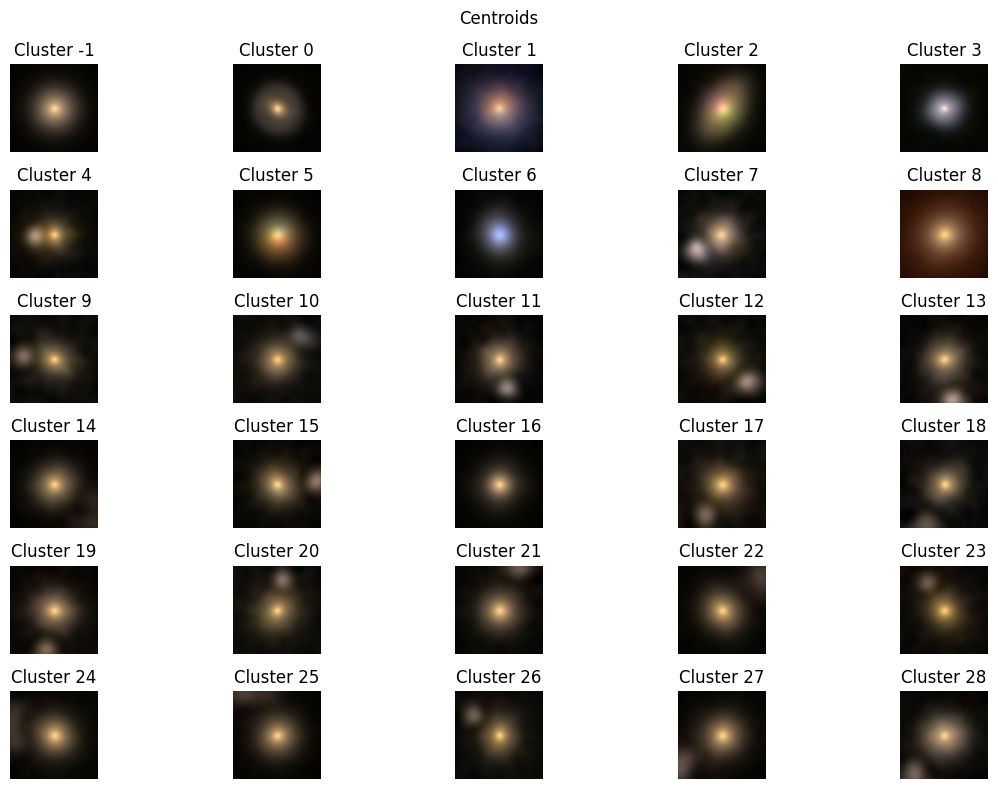

In [ ]:
# Get unique cluster labels from the test data predictions

etiquetas = np.unique(labels)

# Create a figure to visualize cluster centroids
plt.figure(figsize=(12, 8))

# Determine the number of rows needed for the subplot grid
filas = math.ceil(len(etiquetas) / 5)

# Iterate over each cluster label
for clus in etiquetas:
    centroides = []  # List to store all data points in the cluster

    # Collect all samples belonging to the current cluster
    for i in range(len(labels)):
        if labels[i] == clus:
            centroides.append(train_data[i])  # Append PCA-transformed sample

    # Compute the mean (centroid) of all points in the cluster
    center = np.mean(centroides, axis=0)

    # Convert the centroid back to an image format
    img = single_reconverter(center)

    # Plot the centroid image in a grid, adjusting for correct indexing
    plt.subplot(filas, 5, clus + 2)  # Ensure subplot index starts from 1
    plt.imshow(img)

    # Set the cluster label as the title
    plt.title(f'Cluster {clus}')
    plt.axis('off')  # Hide axes for a cleaner visualization

# Set a global title for the figure
plt.suptitle('Centroids')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig(f'{root_result}Centroides_Train_HDB.pdf')
# Display the visualization
plt.show()


In [ ]:
# Initialize subplot index
ploteo = 1

# Create a figure with dynamic height based on the number of clusters
plt.figure(figsize=(10, 3 * n_clusters))

# Iterate over each unique cluster label
for etq in etiquetas:
    cuenta = 0  # Counter to limit the number of images per cluster

    # Loop through all samples in the dataset
    for i in range(len(labels)):

        # Select images that belong to the current cluster
        if etq == labels[i]:
            cuenta += 1  # Count images plotted for the cluster

            # Convert the PCA-transformed sample back to an image
            img = single_reconverter(train_data[i])

            # Plot the image in a grid (clusters x 5 layout)
            plt.subplot(n_clusters, 5, ploteo)
            plt.imshow(img)
            plt.axis('off')  # Hide axis for cleaner visualization

            # Set a title for the third image in each cluster
            if cuenta == 3:
                plt.title(f'Cluster {etq}')

            ploteo += 1  # Increment subplot index

        # Stop after plotting 5 images per cluster
        if cuenta == 5:
            break

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig(f'{root_result}Clusters_Train_HDB.pdf')
# Display the figure
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Initialize subplot index
ploteo = 1

# Create a figure with dynamic height based on the number of clusters
plt.figure(figsize=(10, 3 * n_clusters))


# Loop through all samples in the dataset
for i in range(len(labels)):
    # Select images that belong to the current cluster
    if etiquetas[0] == labels[i]:
        cuenta += 1  # Count images plotted for the cluster

        # Convert the PCA-transformed sample back to an image
        img = single_reconverter(train_data[i])

        # Plot the image in a grid (clusters x 5 layout)
        plt.subplot(n_clusters, 5, ploteo)
        plt.imshow(img)
        plt.axis('off')  # Hide axis for cleaner visualization


        ploteo += 1  # Increment subplot index

    # Stop after plotting 5 images per cluster
    if ploteo > int(n_clusters*5):
        break
plt.suptitle('Cluster ruido', y=1.00003)
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig(f'{root_result}Exploracion_ruido_HDB.pdf')
# Display the figure
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Test

## Load Train Data

In [ ]:
# Load dataset from drive

test_data = load_data('test')

# Compute pairwise cosine distances for the training data

test_cosine_dist = cosine_distances(test_data)

test data loaded
Shape: (10000, 75)


In [ ]:
# Initialize HDBSCAN clustering with precomputed cosine distances

hdb = hdbscan.HDBSCAN(
    metric='precomputed',             # Use a precomputed distance matrix (cosine distance)
    min_cluster_size=6,               # Minimum number of points required to form a cluster
    cluster_selection_epsilon=0.3,    # Controls the minimum separation between clusters
    cluster_selection_method="leaf",  # Selects clusters from the most refined partition
    gen_min_span_tree=True,           # Generates the minimum spanning tree for visualization
    prediction_data=True
)

# Fit the HDBSCAN model to the precomputed cosine distance matrix
hdb.fit(test_cosine_dist)  # Ensure that 'train_cosine_dist' contains pairwise distances


/usr/local/lib/python3.11/dist-packages/hdbscan/hdbscan_.py:1320: UserWarning: Cannot generate prediction data for non-vectorspace inputs -- access to the source data ratherthan mere distances is required!
  warn(


HDBSCAN(cluster_selection_epsilon=0.3, cluster_selection_method='leaf',
        gen_min_span_tree=True, metric='precomputed', min_cluster_size=6,
        prediction_data=True)

## Minimus Spanning Tree

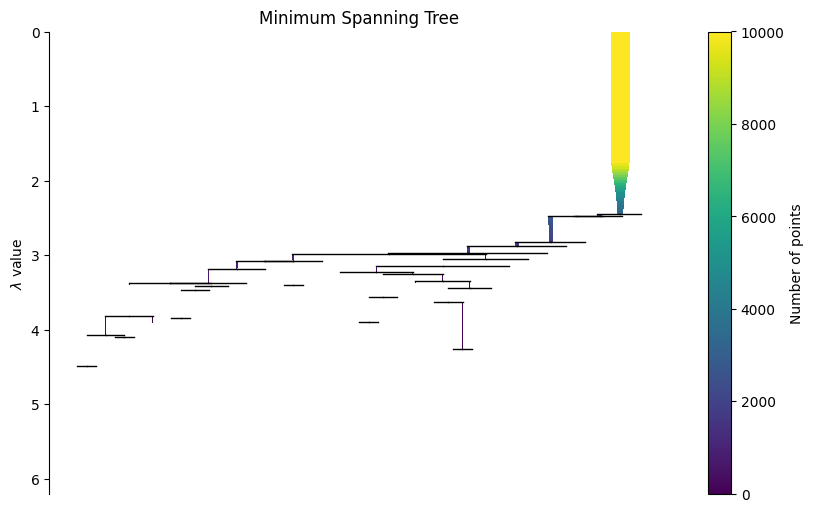

In [ ]:
# Create a figure for visualizing the hierarchical clustering tree
plt.figure(figsize=(10, 6))

# Plot the condensed hierarchical tree generated by HDBSCAN
hdb.condensed_tree_.plot()

# Set the title for the plot
plt.title("Minimum Spanning Tree")

plt.savefig(f'{root_result}Arbol_de_minima_expansion_Test_HDB.pdf')

# Display the tree plot
plt.show()


## Clasification

In [ ]:
# Predict cluster labels for the test dataset using the trained HC model

labels = hdb.labels_

log_data_test['prediction'] = labels
display(log_data_test.head())

# Obtain the number of clusters

n_clusters = len(np.unique(labels))

,dr7objid,asset_id,gz2_class,prediction
0,587741727649300599,159627,Er,-1
1,587742629600624749,180167,SB,-1
2,588011103182127299,199851,Sc,-1
3,587744727151345789,185584,Sc,-1
4,587732769986707556,61265,Sc,-1


## Histogram

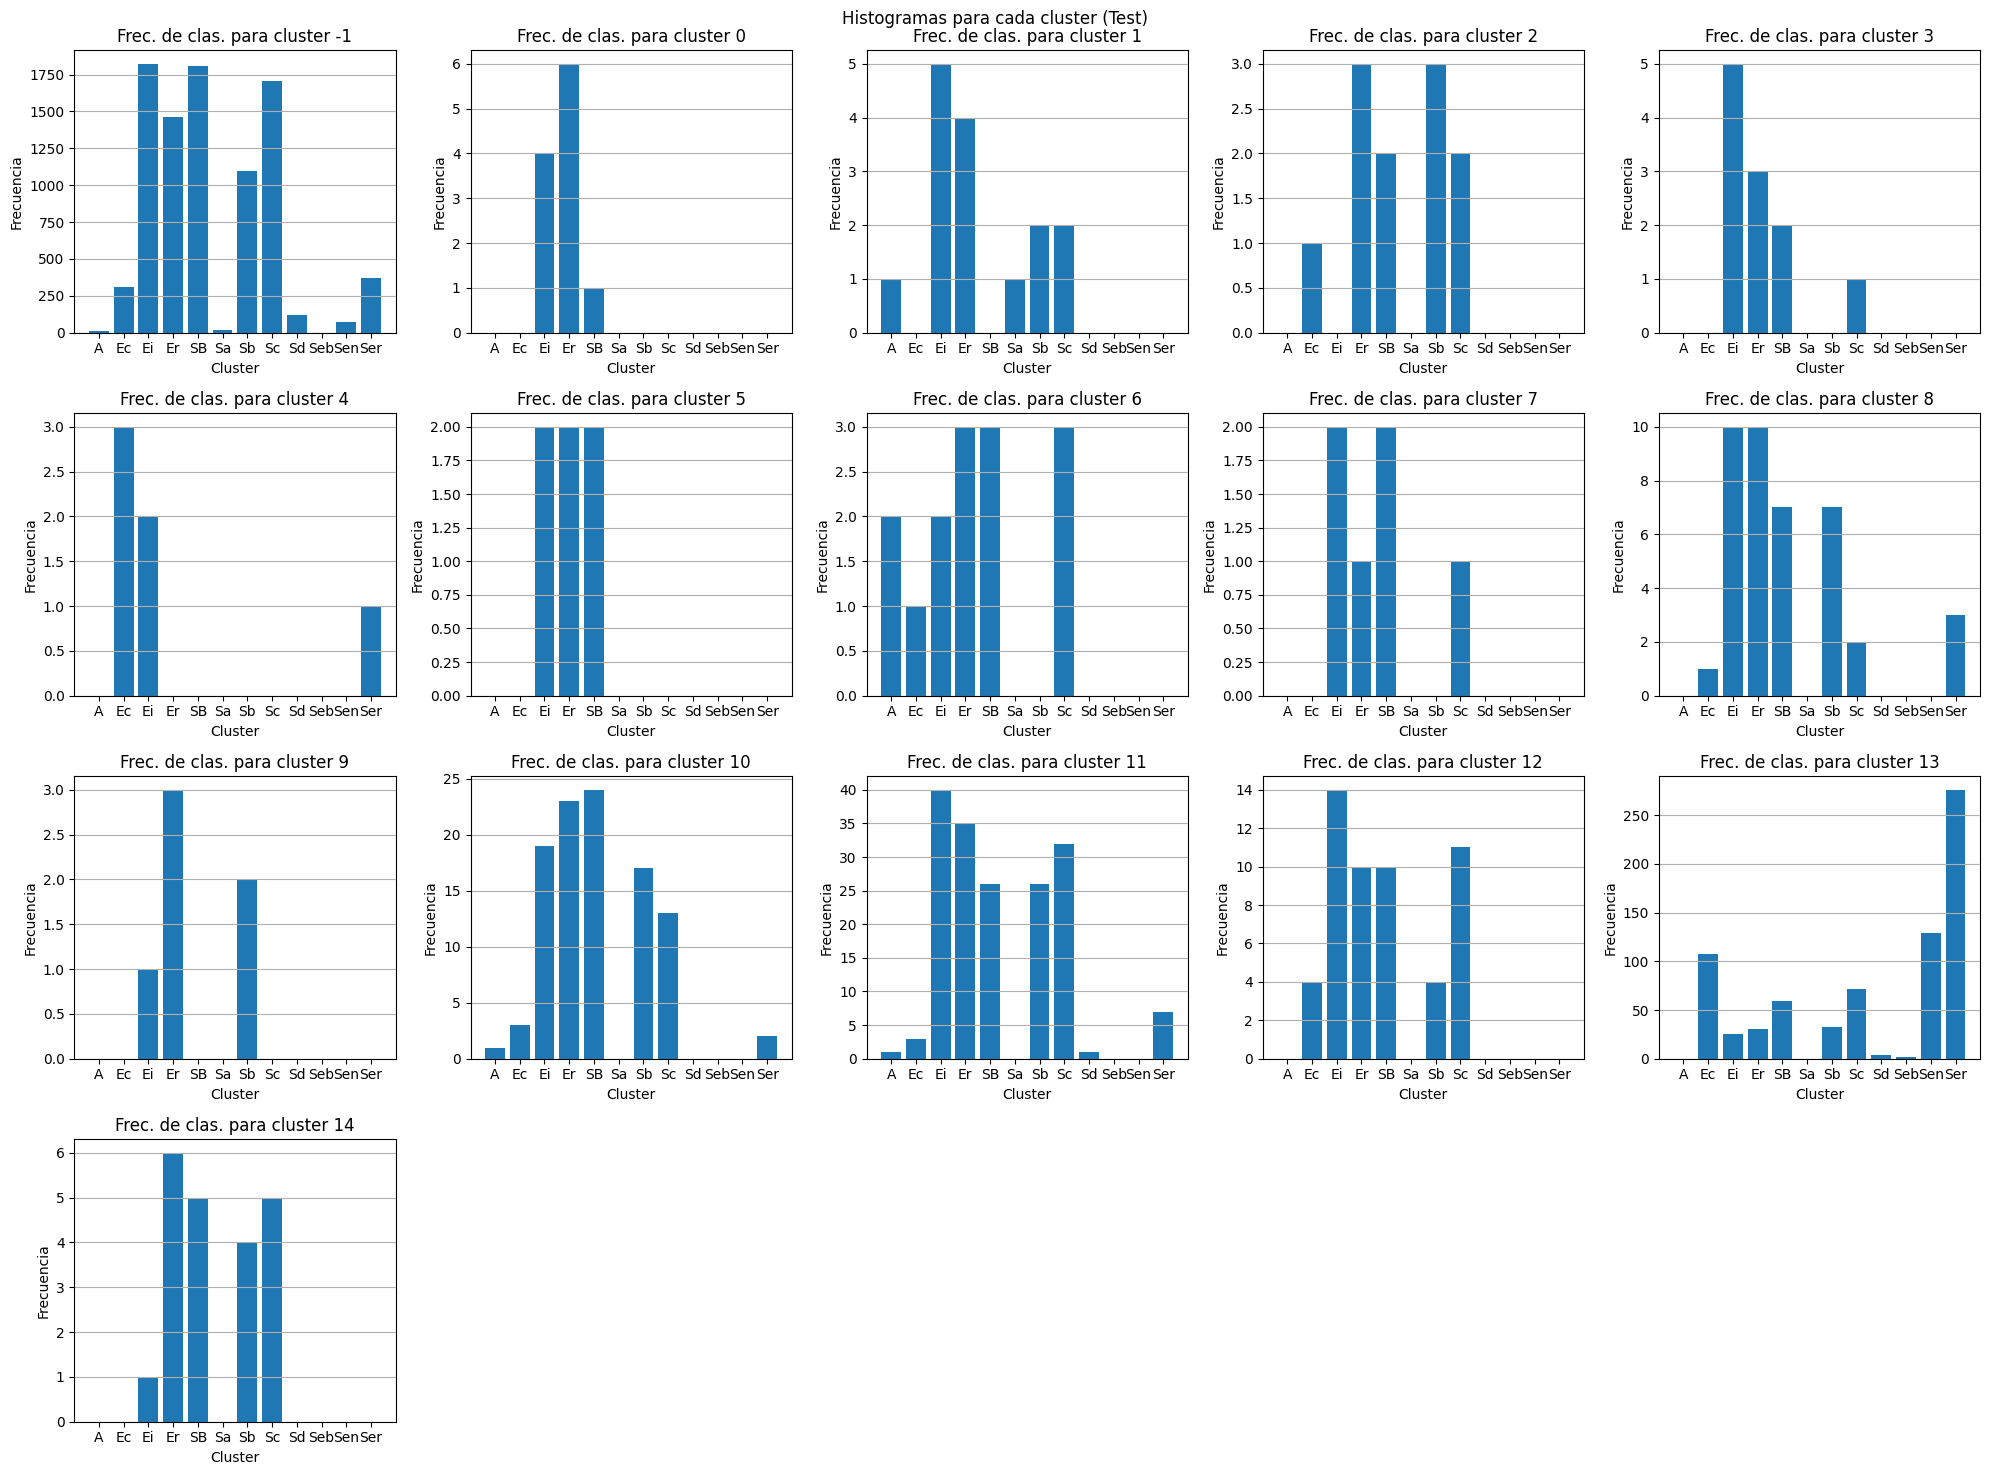

In [ ]:
# Generate histograms for each cluster showing the distribution of galaxy classes in the testing dataset
clusters_histograms(log_data_test,'Test')

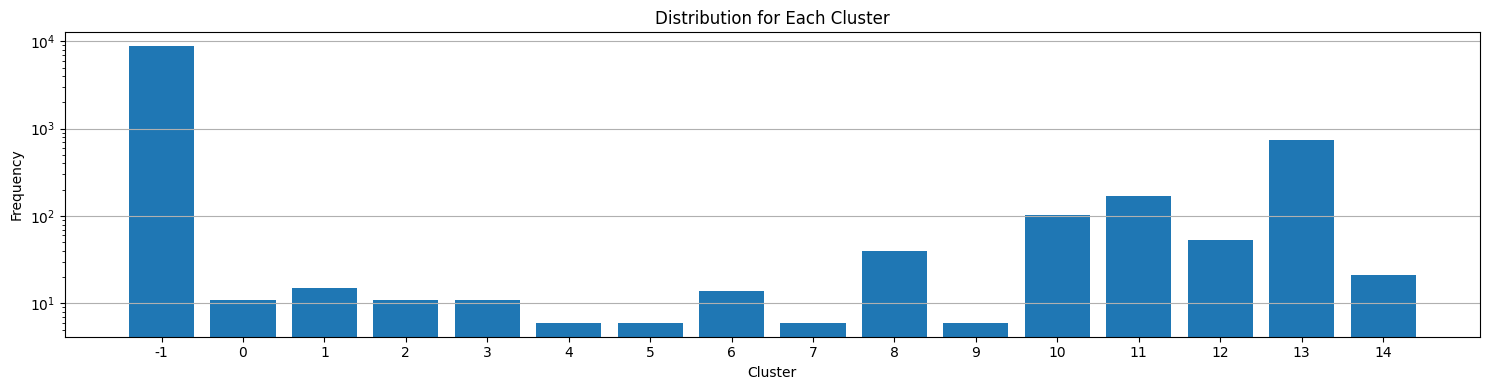

In [ ]:
# Plot and save a histogram showing the distribution of cluster labels in the testing data
histogram(labels, n_clusters, 'Histograma_Test_HDB')

## Centroids

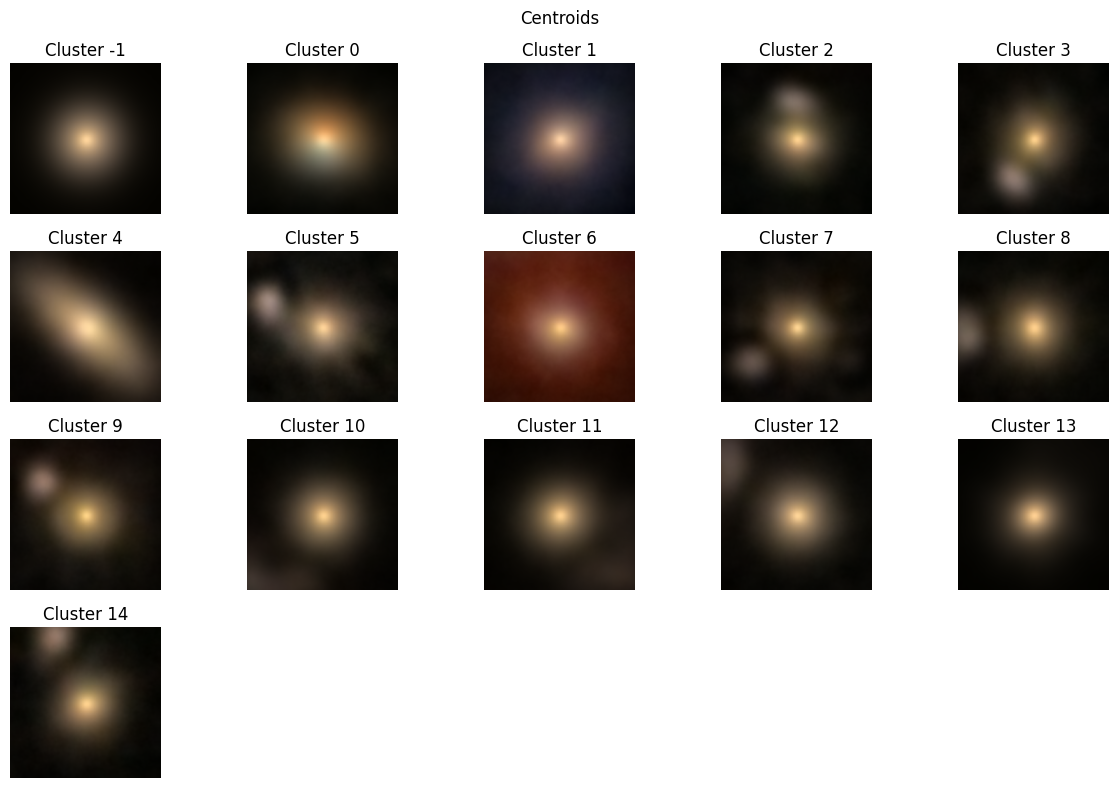

In [ ]:
# Get unique cluster labels from the test data predictions

etiquetas = np.unique(labels)

# Create a figure to visualize cluster centroids
plt.figure(figsize=(12, 8))

# Determine the number of rows needed for the subplot grid
filas = math.ceil(len(etiquetas) / 5)

# Iterate over each cluster label
for clus in etiquetas:
    centroides = []  # List to store all data points in the cluster

    # Collect all samples belonging to the current cluster
    for i in range(len(labels)):
        if labels[i] == clus:
            centroides.append(test_data[i])  # Append PCA-transformed sample

    # Compute the mean (centroid) of all points in the cluster
    center = np.mean(centroides, axis=0)

    # Convert the centroid back to an image format
    img = single_reconverter(center)

    # Plot the centroid image in a grid, adjusting for correct indexing
    plt.subplot(filas, 5, clus + 2)  # Ensure subplot index starts from 1
    plt.imshow(img)

    # Set the cluster label as the title
    plt.title(f'Cluster {clus}')
    plt.axis('off')  # Hide axes for a cleaner visualization

# Set a global title for the figure
plt.suptitle('Centroids')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig(f'{root_result}Centroides_test_HDB.pdf')
# Display the visualization
plt.show()


In [ ]:
# Initialize subplot index
ploteo = 1

# Create a figure with dynamic height based on the number of clusters
plt.figure(figsize=(10, 3 * n_clusters))

# Iterate over each unique cluster label
for etq in etiquetas:
    cuenta = 0  # Counter to limit the number of images per cluster

    # Loop through all samples in the dataset
    for i in range(len(labels)):

        # Select images that belong to the current cluster
        if etq == labels[i]:
            cuenta += 1  # Count images plotted for the cluster

            # Convert the PCA-transformed sample back to an image
            img = single_reconverter(test_data[i])

            # Plot the image in a grid (clusters x 5 layout)
            plt.subplot(n_clusters, 5, ploteo)
            plt.imshow(img)
            plt.axis('off')  # Hide axis for cleaner visualization

            # Set a title for the third image in each cluster
            if cuenta == 3:
                plt.title(f'Cluster {etq}')

            ploteo += 1  # Increment subplot index

        # Stop after plotting 5 images per cluster
        if cuenta == 5:
            break

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig(f'{root_result}Clusters_Test_HDB.pdf')
# Display the figure
plt.show()


Output hidden; open in https://colab.research.google.com to view.